In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'fmnist'

In [7]:
from tensorflow.keras.datasets import fashion_mnist

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [9]:
from tfumap.vae import VAE, Sampling

In [10]:
dims = (28,28,1)
n_components = 2

encoder_inputs = tf.keras.Input(shape=dims)
x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    )(encoder_inputs)
x = tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    )(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512, activation="relu")(x)
z_mean = tf.keras.layers.Dense(n_components, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(n_components, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 128)    73856       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4608)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
latent_inputs = tf.keras.Input(shape=(n_components,))
x = tf.keras.layers.Dense(units=512, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu")(x)
x = tf.keras.layers.Reshape(target_shape=(7, 7, 256))(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    )(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 12544)             6435072   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         577 

### Create model and train

In [12]:
X_train.shape

(50000, 784)

In [13]:
X_train = X_train.reshape((len(X_train), 28,28,1))
X_train.shape

(50000, 28, 28, 1)

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [15]:
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 8s 21ms/step - loss: 296.3271 - reconstruction_loss: 292.9405 - kl_loss: 3.3866
Epoch 2/30
391/391 [==============================] - 9s 23ms/step - loss: 265.3379 - reconstruction_loss: 261.9402 - kl_loss: 3.3976
Epoch 3/30
391/391 [==============================] - 10s 25ms/step - loss: 261.4831 - reconstruction_loss: 258.0386 - kl_loss: 3.4445 6s - loss: 261.9698 - reconstruction_loss: 258.5213 -
Epoch 4/30
391/391 [==============================] - 9s 23ms/step - loss: 259.4157 - reconstruction_loss: 255.9421 - kl_loss: 3.4737
Epoch 5/30
391/391 [==============================] - 10s 24ms/step - loss: 258.2354 - reconstruction_loss: 254.7104 - kl_loss: 3.5250
Epoch 6/30
391/391 [==============================] - 10s 25ms/step - loss: 257.1587 - reconstruction_loss: 253.6291 - kl_loss: 3.5296
Epoch 7/30
391/391 [==============================] - 10s 25ms/step - loss: 256.5181 - reconstruction_loss: 252.9653 - kl_loss: 3.5528
Epoc

In [16]:
# z = embedder.fit_transform(X_train_flat)

In [17]:
z = vae.encoder.predict(X_train)[0]

### Plot model output

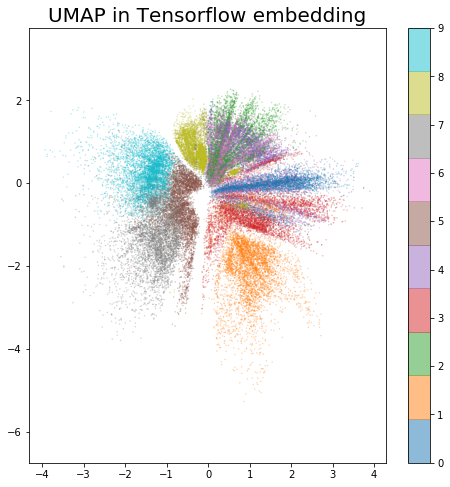

In [18]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [19]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [20]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [21]:
output_dir = MODEL_DIR/'projections'/ dataset / 'vae'
ensure_dir(output_dir)

In [22]:
#vae.save(output_dir)

In [23]:
vae.encoder.save(output_dir / 'encoder')

W0821 22:18:58.460498 139962693293888 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
W0821 22:18:58.528464 139962693293888 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I0821 22:19:00.001443 139962693293888 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/vae/en

In [24]:
vae.decoder.save(output_dir / 'encoder')

I0821 22:19:02.808744 139962693293888 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/vae/encoder/assets


In [25]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [26]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [27]:
X_test.shape

(10000, 784)

In [28]:
z_test = encoder.predict(X_test.reshape((len(X_test), 28,28,1)))[0]

#### silhouette

In [29]:
from tfumap.silhouette import silhouette_score_block

In [30]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.1064451891396579

In [31]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.10361276144714716

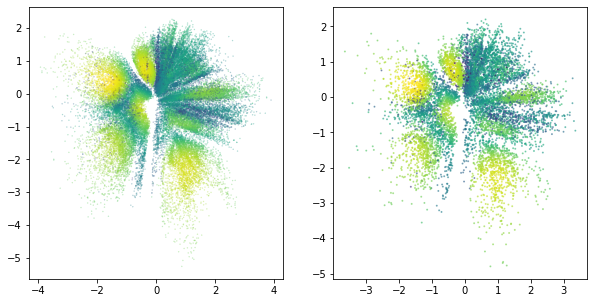

In [32]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.7161

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.6646

#### Trustworthiness

In [36]:
from sklearn.manifold import trustworthiness

In [37]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [38]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [39]:
tw, tw_test

(0.975138190552442, 0.9681411769415532)

### Save output metrics

In [40]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [41]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,fmnist,vae,2,0.975138,0.106445,"[0.5898871281951917, 0.33593613657283483, -0.1..."


In [42]:
save_loc = DATA_DIR / 'projection_metrics' /  'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [43]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,fmnist,vae,2,0.968141,0.103613,"[0.16392628284734986, 0.05248242531883385, 0.4..."


In [44]:
save_loc = DATA_DIR / 'projection_metrics' / 'vae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [45]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['vae', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,vae,2,fmnist,0.6646,0.7161


In [46]:
save_loc = DATA_DIR / 'knn_classifier' / 'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [48]:
X_recon = vae.decoder.predict(vae.encoder.predict(X_test.reshape((len(X_test), 28, 28, 1)))[0])
X_real = X_test.reshape((len(X_test), 28, 28, 1))

In [49]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [50]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [51]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['vae', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,vae,2,fmnist,0.025333,0.087578,0.040589,0.612928


In [52]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'vae' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [54]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [55]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'vae', z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,fmnist,vae,"[[-1.3781811, 0.40604594], [2.0028358, 0.09522...","[9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, ...",2


In [56]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/vae_2_fmnist.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,fmnist,vae,2,0.387865,0.441178,0.663737,0.530043,0,5,"KMeans(n_clusters=5, random_state=0)"
1,fmnist,vae,2,0.387727,0.440974,0.663536,0.529832,1,5,"KMeans(n_clusters=5, random_state=1)"
2,fmnist,vae,2,0.388387,0.441128,0.663989,0.530087,2,5,"KMeans(n_clusters=5, random_state=2)"
3,fmnist,vae,2,0.388862,0.442395,0.666815,0.531902,3,5,"KMeans(n_clusters=5, random_state=3)"
4,fmnist,vae,2,0.387791,0.441233,0.664208,0.530233,4,5,"KMeans(n_clusters=5, random_state=4)"
5,fmnist,vae,2,0.369949,0.463594,0.606276,0.525421,0,6,"KMeans(n_clusters=6, random_state=0)"
6,fmnist,vae,2,0.370176,0.463896,0.607139,0.525939,1,6,"KMeans(n_clusters=6, random_state=1)"
7,fmnist,vae,2,0.370076,0.463272,0.605640,0.524975,2,6,"KMeans(n_clusters=6, random_state=2)"
8,fmnist,vae,2,0.370059,0.463793,0.607020,0.525828,3,6,"KMeans(n_clusters=6, random_state=3)"
9,fmnist,vae,2,0.369953,0.463080,0.605243,0.524703,4,6,"KMeans(n_clusters=6, random_state=4)"
